In [1]:
# Train on RAF-DB
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")
torch.cuda.empty_cache()


CUDA available: True
Device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 3070


In [2]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt

from approach.ResEmoteNet import ResEmoteNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Transform the dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
# Load the model
model = ResEmoteNet()
model.to('cuda')
# Print the number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')

Using cuda device
80,238,599 total parameters.


In [4]:
import os
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

def load_data(base_dir, batch_size=16, transform=None):
    """
    Function to load train and test datasets and return their DataLoaders.

    Args:
        base_dir (str): Base directory containing train/test subdirectories.
        batch_size (int): Batch size for the DataLoader.
        transform (callable, optional): Transformations to apply to the images.

    Returns:
        tuple: Train DataLoader, Validation DataLoader
    """
    # Define train and test directories
    train_dir = os.path.join(base_dir, "train")
    val_dir = os.path.join(base_dir, "test")
    
    # Use torchvision.datasets.ImageFolder to automatically handle class folders
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
    
    label_names = train_dataset.classes

    # Split train_dataset into training and validation sets
    val_size = 2000
    train_size = len(train_dataset) - val_size
    train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

    # DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    

    # Print dataset sizes
    print(f"Number of images in train loader: {len(train_loader.dataset)}")
    print(f"Number of images in val loader: {len(val_loader.dataset)}")
    print(f"Number of images in test loader: {len(test_loader.dataset)}")

    return train_loader, test_loader, val_loader, label_names


# Load data
base_dir = "/workspace/RAF-DB"
train_loader, test_loader, val_loader, label_names = load_data(base_dir=base_dir, batch_size=16, transform=transform)

# Inspect a batch
train_images, train_labels = next(iter(train_loader))
print(f"Train batch: Images shape {train_images.shape}, Labels shape {train_labels.shape}")

test_images, test_labels = next(iter(test_loader))
print(f"Train batch: Images shape {test_images.shape}, Labels shape {test_labels.shape}")


Number of images in train loader: 10271
Number of images in val loader: 2000
Number of images in test loader: 3068
Train batch: Images shape torch.Size([16, 3, 64, 64]), Labels shape torch.Size([16])
Train batch: Images shape torch.Size([16, 3, 64, 64]), Labels shape torch.Size([16])


In [5]:
# Hyperparameters
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

patience = 15
best_val_acc = 0
patience_counter = 0
epoch_counter = 0

num_epochs = 80

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
test_losses = []
test_accuracies = []

In [6]:
# Start training
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_running_loss / len(test_loader)
    test_acc = test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_acc}, Test Loss: {test_loss}, Test Accuracy: {test_acc}, Val Loss: {val_loss}, Val Accuracy: {val_acc}")
    epoch_counter += 1
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0 
        torch.save(model.state_dict(), 'best_mode_RAF-DB.pth')
    else:
        patience_counter += 1
        print(f"No improvement in validation accuracy for {patience_counter} epochs.")
    
    if patience_counter > patience:
        print("Stopping early due to lack of improvement in validation accuracy.")
        break

Epoch 1/80: 100% 642/642 [00:25<00:00, 25.29it/s]


Epoch 1, Train Loss: 1.5498930980854688, Train Accuracy: 0.42342517768474347, Test Loss: 1.3236449738809217, Test Accuracy: 0.5035853976531942, Val Loss: 1.3280902051925658, Val Accuracy: 0.4985


Epoch 2/80: 100% 642/642 [00:24<00:00, 25.69it/s]


Epoch 2, Train Loss: 1.2874866349860514, Train Accuracy: 0.5310096387888229, Test Loss: 1.1161061816383153, Test Accuracy: 0.6108213820078227, Val Loss: 1.1324427480697632, Val Accuracy: 0.5935


Epoch 3/80: 100% 642/642 [00:25<00:00, 25.67it/s]


Epoch 3, Train Loss: 1.124233930374603, Train Accuracy: 0.6078278648622335, Test Loss: 0.9541455982301462, Test Accuracy: 0.6704693611473272, Val Loss: 1.0036102299690246, Val Accuracy: 0.646


Epoch 4/80: 100% 642/642 [00:24<00:00, 25.73it/s]


Epoch 4, Train Loss: 1.0106423146720986, Train Accuracy: 0.6499853957745108, Test Loss: 0.8778545110738681, Test Accuracy: 0.7017601043024772, Val Loss: 0.8903742861747742, Val Accuracy: 0.689


Epoch 5/80: 100% 642/642 [00:25<00:00, 25.67it/s]


Epoch 5, Train Loss: 0.9346455010669625, Train Accuracy: 0.6774413396942849, Test Loss: 0.8273976544733159, Test Accuracy: 0.704367666232073, Val Loss: 0.8384939825534821, Val Accuracy: 0.6965


Epoch 6/80: 100% 642/642 [00:25<00:00, 25.63it/s]


Epoch 6, Train Loss: 0.8528105036306233, Train Accuracy: 0.7060656216531983, Test Loss: 0.7624886011908529, Test Accuracy: 0.7372881355932204, Val Loss: 0.7718721565008163, Val Accuracy: 0.7415


Epoch 7/80: 100% 642/642 [00:24<00:00, 25.70it/s]


Epoch 7, Train Loss: 0.8067018088893355, Train Accuracy: 0.7187226170772076, Test Loss: 0.7566271852920181, Test Accuracy: 0.7464146023468058, Val Loss: 0.7872769922018051, Val Accuracy: 0.7365
No improvement in validation accuracy for 1 epochs.


Epoch 8/80: 100% 642/642 [00:24<00:00, 25.70it/s]


Epoch 8, Train Loss: 0.7501001591994384, Train Accuracy: 0.7453023074676273, Test Loss: 0.7204569240081279, Test Accuracy: 0.7415254237288136, Val Loss: 0.7606076326370239, Val Accuracy: 0.735
No improvement in validation accuracy for 2 epochs.


Epoch 9/80: 100% 642/642 [00:24<00:00, 25.69it/s]


Epoch 9, Train Loss: 0.6944123685499218, Train Accuracy: 0.7570830493622821, Test Loss: 0.710831876853869, Test Accuracy: 0.7467405475880052, Val Loss: 0.7232517970204353, Val Accuracy: 0.7535


Epoch 10/80: 100% 642/642 [00:25<00:00, 25.62it/s]


Epoch 10, Train Loss: 0.6547443684991275, Train Accuracy: 0.7784052185765749, Test Loss: 0.732399484631363, Test Accuracy: 0.7470664928292047, Val Loss: 0.7249384322166443, Val Accuracy: 0.7485
No improvement in validation accuracy for 1 epochs.


Epoch 11/80: 100% 642/642 [00:25<00:00, 25.27it/s]


Epoch 11, Train Loss: 0.6147154391368973, Train Accuracy: 0.7914516600136307, Test Loss: 0.7510903648605259, Test Accuracy: 0.7376140808344198, Val Loss: 0.7335610738992691, Val Accuracy: 0.7555


Epoch 12/80: 100% 642/642 [00:26<00:00, 24.69it/s]


Epoch 12, Train Loss: 0.5746459590265313, Train Accuracy: 0.8048875474637328, Test Loss: 0.7077880282607415, Test Accuracy: 0.7555410691003911, Val Loss: 0.7006878449916839, Val Accuracy: 0.768


Epoch 13/80: 100% 642/642 [00:25<00:00, 24.79it/s]


Epoch 13, Train Loss: 0.5353925268389168, Train Accuracy: 0.8181287119073118, Test Loss: 0.6643232475616969, Test Accuracy: 0.7796610169491526, Val Loss: 0.6734608283638954, Val Accuracy: 0.784


Epoch 14/80: 100% 642/642 [00:25<00:00, 24.73it/s]


Epoch 14, Train Loss: 0.5001227896997119, Train Accuracy: 0.8302015383117516, Test Loss: 0.687683543668148, Test Accuracy: 0.7646675358539765, Val Loss: 0.703358755171299, Val Accuracy: 0.7745
No improvement in validation accuracy for 1 epochs.


Epoch 15/80: 100% 642/642 [00:25<00:00, 24.80it/s]


Epoch 15, Train Loss: 0.46137127153737895, Train Accuracy: 0.8434427027553305, Test Loss: 0.6862547012096911, Test Accuracy: 0.771838331160365, Val Loss: 0.7186082758903504, Val Accuracy: 0.7745
No improvement in validation accuracy for 2 epochs.


Epoch 16/80: 100% 642/642 [00:25<00:00, 24.87it/s]


Epoch 16, Train Loss: 0.4275072687116924, Train Accuracy: 0.8523999610553987, Test Loss: 0.6838021302828565, Test Accuracy: 0.7689048239895697, Val Loss: 0.720860656619072, Val Accuracy: 0.772
No improvement in validation accuracy for 3 epochs.


Epoch 17/80: 100% 642/642 [00:25<00:00, 24.72it/s]


Epoch 17, Train Loss: 0.3925098139833299, Train Accuracy: 0.8664200175250706, Test Loss: 0.6936023931032954, Test Accuracy: 0.7936766623207301, Val Loss: 0.7256551070213317, Val Accuracy: 0.786


Epoch 18/80: 100% 642/642 [00:25<00:00, 24.78it/s]


Epoch 18, Train Loss: 0.3689161079828381, Train Accuracy: 0.8732353227533833, Test Loss: 0.6787728832568973, Test Accuracy: 0.7910691003911343, Val Loss: 0.7122972544431686, Val Accuracy: 0.794


Epoch 19/80: 100% 642/642 [00:25<00:00, 24.78it/s]


Epoch 19, Train Loss: 0.34229617585018973, Train Accuracy: 0.8850160646480382, Test Loss: 0.7164244191032291, Test Accuracy: 0.7858539765319427, Val Loss: 0.7813278748989105, Val Accuracy: 0.7665
No improvement in validation accuracy for 1 epochs.


Epoch 20/80: 100% 642/642 [00:25<00:00, 24.87it/s]


Epoch 20, Train Loss: 0.31733581027439633, Train Accuracy: 0.8934865154317982, Test Loss: 0.7602483188723758, Test Accuracy: 0.7715123859191656, Val Loss: 0.8280835964679718, Val Accuracy: 0.766
No improvement in validation accuracy for 2 epochs.


Epoch 21/80: 100% 642/642 [00:25<00:00, 24.73it/s]


Epoch 21, Train Loss: 0.2964617780139931, Train Accuracy: 0.9032226657579593, Test Loss: 0.7118285343477359, Test Accuracy: 0.7891134289439374, Val Loss: 0.7698549286127091, Val Accuracy: 0.775
No improvement in validation accuracy for 3 epochs.


Epoch 22/80: 100% 642/642 [00:25<00:00, 24.83it/s]


Epoch 22, Train Loss: 0.28022815039340765, Train Accuracy: 0.9054619803329763, Test Loss: 0.7311606893114609, Test Accuracy: 0.7770534550195567, Val Loss: 0.7774437708854676, Val Accuracy: 0.7715
No improvement in validation accuracy for 4 epochs.


Epoch 23/80: 100% 642/642 [00:25<00:00, 24.77it/s]


Epoch 23, Train Loss: 0.24846894692519325, Train Accuracy: 0.917534806737416, Test Loss: 0.7698761197389103, Test Accuracy: 0.7803129074315515, Val Loss: 0.8060522890090942, Val Accuracy: 0.7835
No improvement in validation accuracy for 5 epochs.


Epoch 24/80: 100% 642/642 [00:25<00:00, 24.80it/s]


Epoch 24, Train Loss: 0.22971222755090098, Train Accuracy: 0.9226949664102814, Test Loss: 0.7499572448529458, Test Accuracy: 0.7610821382007823, Val Loss: 0.7988754073381424, Val Accuracy: 0.763
No improvement in validation accuracy for 6 epochs.


Epoch 25/80: 100% 642/642 [00:25<00:00, 24.80it/s]


Epoch 25, Train Loss: 0.22366259950053563, Train Accuracy: 0.9261026190244377, Test Loss: 0.8167158893772163, Test Accuracy: 0.772490221642764, Val Loss: 0.8175266624689103, Val Accuracy: 0.779
No improvement in validation accuracy for 7 epochs.


Epoch 26/80: 100% 642/642 [00:25<00:00, 25.00it/s]


Epoch 26, Train Loss: 0.19840628872886648, Train Accuracy: 0.9349625158212442, Test Loss: 0.8614048954177633, Test Accuracy: 0.7848761408083442, Val Loss: 0.9243897959887981, Val Accuracy: 0.7695
No improvement in validation accuracy for 8 epochs.


Epoch 27/80: 100% 642/642 [00:26<00:00, 24.64it/s]


Epoch 27, Train Loss: 0.1920519094773484, Train Accuracy: 0.9384675299386622, Test Loss: 0.8165769585881814, Test Accuracy: 0.7904172099087353, Val Loss: 0.8168855522274971, Val Accuracy: 0.7805
No improvement in validation accuracy for 9 epochs.


Epoch 28/80: 100% 642/642 [00:25<00:00, 24.80it/s]


Epoch 28, Train Loss: 0.17830414805565656, Train Accuracy: 0.9439197741213124, Test Loss: 0.8242708257803315, Test Accuracy: 0.7747718383311604, Val Loss: 0.846471121430397, Val Accuracy: 0.774
No improvement in validation accuracy for 10 epochs.


Epoch 29/80: 100% 642/642 [00:25<00:00, 24.74it/s]


Epoch 29, Train Loss: 0.1623182131613625, Train Accuracy: 0.9485931262778697, Test Loss: 0.8795786319136217, Test Accuracy: 0.772490221642764, Val Loss: 0.9412975806593895, Val Accuracy: 0.756
No improvement in validation accuracy for 11 epochs.


Epoch 30/80: 100% 642/642 [00:26<00:00, 24.63it/s]


Epoch 30, Train Loss: 0.16833335025862695, Train Accuracy: 0.9431408820952195, Test Loss: 0.8901135910249044, Test Accuracy: 0.766297262059974, Val Loss: 0.8812585730850696, Val Accuracy: 0.763
No improvement in validation accuracy for 12 epochs.


Epoch 31/80: 100% 642/642 [00:26<00:00, 24.59it/s]


Epoch 31, Train Loss: 0.14562116799305985, Train Accuracy: 0.9526823094148573, Test Loss: 0.8892490649891442, Test Accuracy: 0.7790091264667536, Val Loss: 0.8449692537784577, Val Accuracy: 0.7785
No improvement in validation accuracy for 13 epochs.


Epoch 32/80: 100% 642/642 [00:25<00:00, 24.93it/s]


Epoch 32, Train Loss: 0.1194374367637876, Train Accuracy: 0.9591081686301236, Test Loss: 0.9586507266616687, Test Accuracy: 0.7780312907431551, Val Loss: 0.964258659183979, Val Accuracy: 0.775
No improvement in validation accuracy for 14 epochs.


Epoch 33/80: 100% 642/642 [00:25<00:00, 24.86it/s]


Epoch 33, Train Loss: 0.12713411527833063, Train Accuracy: 0.9584266381072923, Test Loss: 0.9408859849810748, Test Accuracy: 0.7734680573663625, Val Loss: 0.9352895157039165, Val Accuracy: 0.7775
No improvement in validation accuracy for 15 epochs.


Epoch 34/80: 100% 642/642 [00:25<00:00, 24.86it/s]


Epoch 34, Train Loss: 0.12541082793537736, Train Accuracy: 0.9589134456236005, Test Loss: 0.9074709394059634, Test Accuracy: 0.7786831812255541, Val Loss: 0.9669000559449196, Val Accuracy: 0.7675
No improvement in validation accuracy for 16 epochs.
Stopping early due to lack of improvement in validation accuracy.


Results saved to 'result_four4all.csv'.


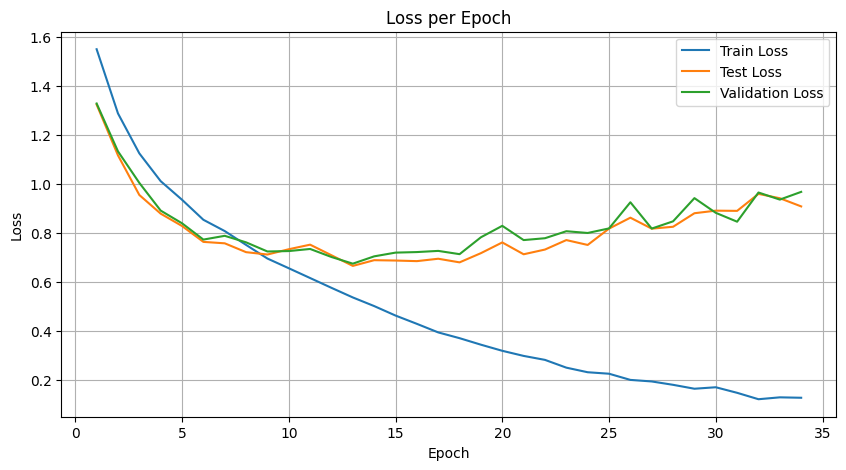

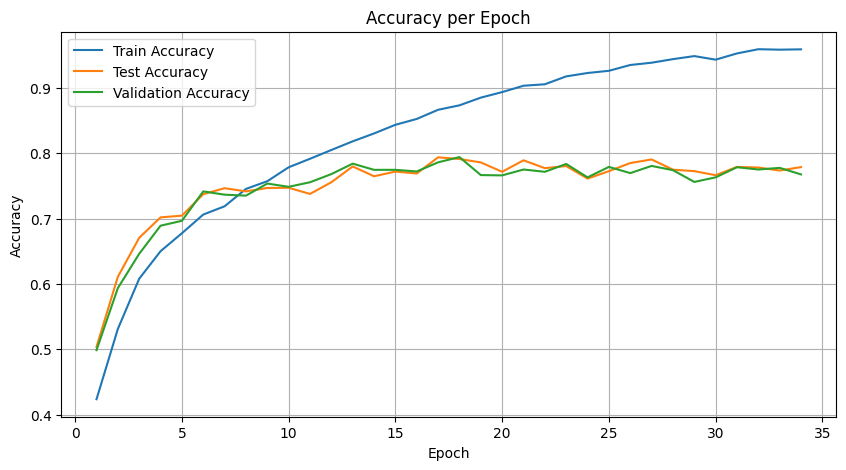

In [7]:
# Truncate the lists to match the number of epochs
train_losses = train_losses[:epoch_counter]
test_losses = test_losses[:epoch_counter]
val_losses = val_losses[:epoch_counter]
train_accuracies = train_accuracies[:epoch_counter]
test_accuracies = test_accuracies[:epoch_counter]
val_accuracies = val_accuracies[:epoch_counter]

# Create the DataFrame
df = pd.DataFrame({
    'Epoch': range(1, epoch_counter + 1),
    'Train Loss': train_losses,
    'Test Loss': test_losses,
    'Validation Loss': val_losses,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Validation Accuracy': val_accuracies
})

# Save the DataFrame to a CSV file
df.to_csv('result_fer2013.csv', index=False)
print("Results saved to 'result_four4all.csv'.")

# Plotting losses
plt.figure(figsize=(10, 5))
plt.plot(df['Epoch'], df['Train Loss'], label='Train Loss')
plt.plot(df['Epoch'], df['Test Loss'], label='Test Loss')
plt.plot(df['Epoch'], df['Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracies
plt.figure(figsize=(10, 5))
plt.plot(df['Epoch'], df['Train Accuracy'], label='Train Accuracy')
plt.plot(df['Epoch'], df['Test Accuracy'], label='Test Accuracy')
plt.plot(df['Epoch'], df['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
import h5py

def save_model_as_h5(model, file_path):
    """
    Save a PyTorch model as an H5 file.

    Args:
        model (torch.nn.Module): The PyTorch model to save.
        file_path (str): Path to save the .h5 file.
    """
    # Convert the model's state_dict to a dictionary of NumPy arrays
    model_weights = {k: v.cpu().numpy() for k, v in model.state_dict().items()}

    with h5py.File(file_path, 'w') as h5_file:
        for key, value in model_weights.items():
            h5_file.create_dataset(key, data=value)
save_model_as_h5(model, "model_RAF-DB.h5")
print("Model saved as modelfer.h5")

Model saved as modelfer.h5


In [9]:
!pip install scikit-learn

Confusion Matrix:
 [[  96    7   11   20    3   14   11]
 [  11   58    0   23   32   29    7]
 [   2    0   39    8    3   11   11]
 [   5   10    4 1107   31   18   10]
 [   4   12    0   64  482   79   39]
 [   3    9    0   64   40  351   11]
 [   2    0   16   10   20    6  275]]


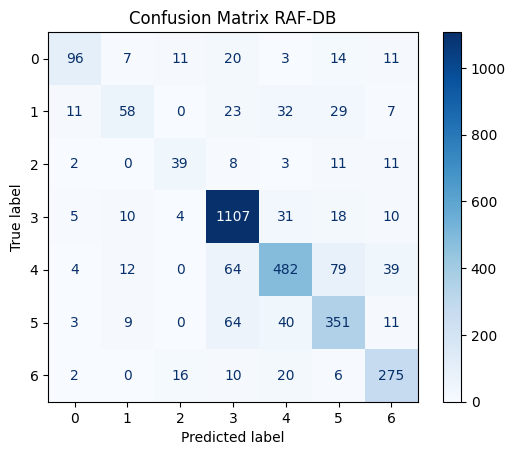

In [10]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Example: Dummy model outputs and labels
y_true = []  # Ground truth labels
y_pred = []  # Predicted labels

# Simulate predictions for test_loader
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # Append predictions and true labels
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix RAF-DB")
plt.show()


Confusion Matrix (Counts):
 [[  94    7   13   24    5   10    9]
 [  10   55    2   21   33   30    9]
 [   1    0   40    9    2   10   12]
 [   7   13    2 1098   37   19    9]
 [   5   11    1   65  483   78   37]
 [   2   11    2   53   46  357    7]
 [   3    0   15   14   26    4  267]]
Confusion Matrix (Percentages):
 [[0.58024691 0.04320988 0.08024691 0.14814815 0.0308642  0.0617284
  0.05555556]
 [0.0625     0.34375    0.0125     0.13125    0.20625    0.1875
  0.05625   ]
 [0.01351351 0.         0.54054054 0.12162162 0.02702703 0.13513514
  0.16216216]
 [0.00590717 0.01097046 0.00168776 0.92658228 0.03122363 0.01603376
  0.00759494]
 [0.00735294 0.01617647 0.00147059 0.09558824 0.71029412 0.11470588
  0.05441176]
 [0.0041841  0.02301255 0.0041841  0.11087866 0.09623431 0.74686192
  0.01464435]
 [0.00911854 0.         0.04559271 0.04255319 0.07902736 0.01215805
  0.81155015]]


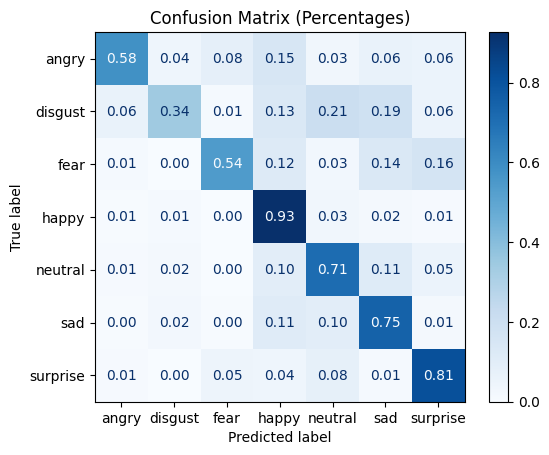

In [11]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Example: Dummy model outputs and labels
y_true = []  # Ground truth labels
y_pred = []  # Predicted labels

# Simulate predictions for test_loader
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # Append predictions and true labels
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix (Counts):\n", conf_matrix)

# Normalize confusion matrix by row (true classes) to get percentages
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True)
print("Confusion Matrix (Percentages):\n", conf_matrix_normalized)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # Display percentages with 2 decimal places
plt.title("Confusion Matrix (Percentages)")
plt.show()
